## Figure 5
Difference in CDNC between 3 surface-partitioning models and constant surface tension at +200m in parcel simulation. 
Columns show results from different models (OV, SL, RU).
Rows show slices through the 3-dimensional phase space of Na-w-Forg.

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [10]:
import numpy as np
import os
from joblib import Parallel, delayed
import pickle as pkl

from matplotlib import pyplot
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap, CenteredNorm
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_names, plot_colors
from PySDM_examples.Singer_Ward.read_mcmc import get_dict_median_parameters

import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

In [28]:
CI = 'CI' in os.environ
n = 4

save = True
restore_saved_data = False

updrafts = np.geomspace(0.1, 10, 3 if CI else n)
forgs = np.linspace(0.05, 0.95, 3 if CI else n)
aerosol_number_concs = np.geomspace(50, 400, 3 if CI else n)
models = ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl')

FORMULAE = Formulae(constants=SINGER_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
aerosol_default = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME)
Ntotal, Ncut = 1000, 500

In [29]:
def genkey(w, Forg, N_a, model):
    return f"w{w:.2f}_f{Forg:.2f}_N{N_a:.2f}_{model}"

if restore_saved_data:
    with open(f"data_fig5_n{n}.pkl",'rb') as file:
        output = pkl.load(file)
    print(output.keys())
else:
    def compute(key, settings):
        simulation = ParcelSimulation(settings)
        output = simulation.run()
        output['updraft'] = settings.w
        output['org_fraction'] = settings.aerosol.modes[0]['f_org']
        output['color'] = settings.aerosol.color
        return key, output

    print(f'tasks scheduled: {len(models) * len(forgs) * len(updrafts) * len(aerosol_number_concs)}')
    output = dict(Parallel(verbose=10, n_jobs=-1)(
        delayed(compute)(genkey(w, Forg, N_a, model), Settings(
            dz = 1 * si.m, 
            n_sd_per_mode = 100, 
            model = model,
            aerosol = AerosolBetaCaryophylleneDark(water_molar_volume=WATER_MOLAR_VOLUME, Forg=Forg, N_a=N_a, r_a=50),
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
            stc = get_dict_median_parameters(model, aerosol_default, Ntotal, Ncut),
        ))
        for w in updrafts
        for Forg in forgs
        for N_a in aerosol_number_concs
        for model in models
    ))

    if save:
        with open(f"data_fig5_n{n}.pkl",'wb') as file:
            pkl.dump(output, file)

tasks scheduled: 256


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.2min
/Users/claresinger/opt/anaconda3/envs/pysdm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: 

(4, 4, 4, 4)


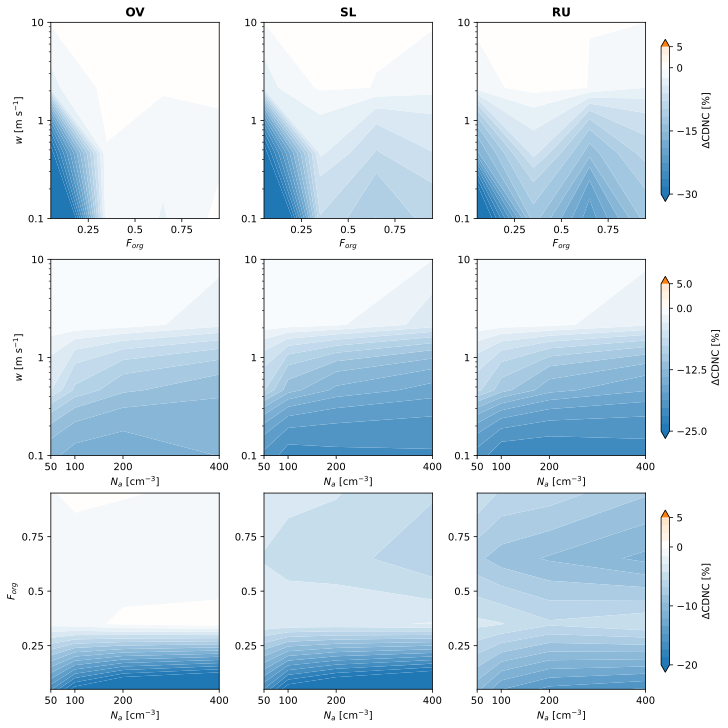

HTML(value="<a href='./fig5.pdf' target='_blank'>./fig5.pdf</a><br>")

In [34]:
dCDNC = np.zeros((len(models), len(updrafts), len(forgs), len(aerosol_number_concs)))
print(np.shape(dCDNC))
for m in range(0,3):
    for i,w in enumerate(updrafts):
        for j,Forg in enumerate(forgs):
            for k,Na in enumerate(aerosol_number_concs):
                key_film = genkey(w, Forg, Na, models[m+1])
                key_bulk = genkey(w, Forg, Na, "Constant")
                z = np.array(output[key_bulk]['z'])
                wz = np.where(z == z[-1])[0][0]
                CDNC_film = np.array(output[key_film]['CDNC_cm3'])[wz]
                CDNC_bulk = np.array(output[key_bulk]['CDNC_cm3'])[wz]
                dCDNC[m,i,j,k] = (CDNC_film - CDNC_bulk) / CDNC_bulk * 100.0

pyplot.rcParams.update({"font.size":10})
fig, axes = pyplot.subplots(3, 4, figsize=(10,10), gridspec_kw={"width_ratios":[1,1,1,0.05]}, layout="constrained")

x = {0:forgs, 1:aerosol_number_concs, 2:aerosol_number_concs}
xlab = {0: "$F_{org}$", 1:"$N_a$ [cm$^{-3}$]", 2:"$N_a$ [cm$^{-3}$]"}
xscale = {0: "linear", 1:"linear", 2:"linear"}
xtickloc = {0:[0.25, 0.5, 0.75], 1:[50, 100, 200, 400], 2:[50, 100, 200, 400]}
xticklab = {0:["0.25", "0.5", "0.75"], 1:["50","100","200","400"], 2:["50","100","200","400"]}

y = {0:updrafts, 1:updrafts, 2:forgs}
ylab = {0: "$w$ [m s$^{-1}$]", 1: "$w$ [m s$^{-1}$]", 2:"$F_{org}$"}
yscale = {0: "log", 1: "log", 2:"linear"}
ytickloc = {0:[0.1,1,10], 1:[0.1,1,10], 2:[0.25, 0.5, 0.75]}
yticklab = {0:["0.1","1","10"], 1:["0.1","1","10"], 2:["0.25", "0.5", "0.75"]}

colors = [plot_colors["CompressedFilmOvadnevaite"], "white", plot_colors["CompressedFilmRuehl"]]  
cmap_name = 'blue_white_orange'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
vmin, vmax = [-30,-25,-20], [5,5,5]

for row in range(0,3):
    for i in range(0,3):
        ax = axes[row, i]
        if row == 0:
            ax.set_title(plot_names[models[i+1]], fontweight="bold")
        
        z = np.mean(dCDNC[i,:,:,:], axis=2-row)
        p = ax.contourf(x[row], y[row], z, 
            cmap=cmap, norm=CenteredNorm(), levels=np.linspace(vmin[row],vmax[row],20), extend="both")
        
        ax.set_xlabel(xlab[row])
        if i == 0:
            ax.set_ylabel(ylab[row])
        ax.set_xscale(xscale[row])
        ax.set_xticks(xtickloc[row], labels=xticklab[row])
        ax.set_yscale(yscale[row])
        ax.set_yticks(ytickloc[row], labels=yticklab[row])

        pyplot.colorbar(p, cax=axes[row,-1], ticks=[vmin[row], vmin[row]/2, 0, vmax[row]], label=r"$\Delta$CDNC [%]")

show_plot("fig5.pdf")